In [1]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from tensorflow.keras.datasets import  cifar10

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [4]:
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse",	"ship",	"truck"]

# MobilenetV2

In [5]:
Img_size = 224
Batch_size = 64

In [6]:
# One-hot encode labels
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

# Define resize size (e.g. 224 for MobileNetV2)
IMG_SIZE = 224
BATCH_SIZE = 16  # adjust based on your GPU RAM

# Create tf.data datasets
X_train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train_cat))
X_test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test_cat))

# Preprocessing function
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))  # resize to (224,224)
    image = preprocess_input(image)                       # MobileNetV2 preprocess
    return image, label

# Apply preprocessing + batching + prefetching
X_train_ds = X_train_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
X_test_ds  = X_test_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [7]:
for images, labels in X_train_ds.take(1):
    print(images.shape)
    print(labels.shape)

(16, 224, 224, 3)
(16, 10)


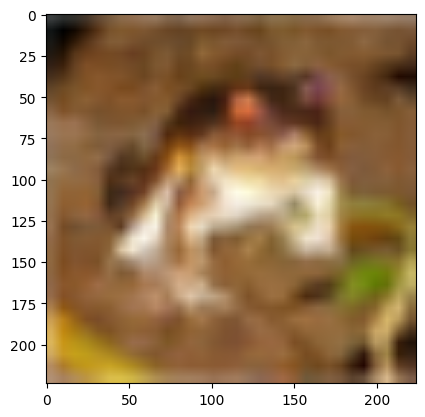

In [8]:
import matplotlib.pyplot as plt

for images, labels in X_train_ds.take(1):
    plt.imshow((images[0].numpy() + 1) / 2)  # MobileNet preprocess_input scales pixels
    plt.show()
    break

In [9]:
# Build transfer learning model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Adam 

In [10]:
model_adam = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(), # Pool spatial features into a vector
    layers.Dense(128, activation='relu'), # Fully connected layer to learn new patterns
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')

])

In [11]:
model_adam.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [13]:
history_adam_mobnet = model_adam.fit(X_train_ds,validation_data=X_test_ds, epochs=10, callbacks= ModelCheckpoint(filepath='mobilenet_adam_bm.keras',monitor='val_loss',
    save_best_only=True,mode='min',verbose=1))

Epoch 1/10
3123/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7293 - loss: 0.8030
Epoch 1: val_loss improved from inf to 0.48239, saving model to mobilenet_adam_bm.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 80s 20ms/step - accuracy: 0.7294 - loss: 0.8029 - val_accuracy: 0.8318 - val_loss: 0.4824
Epoch 2/10
3124/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8196 - loss: 0.5284
Epoch 2: val_loss improved from 0.48239 to 0.46406, saving model to mobilenet_adam_bm.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 57s 18ms/step - accuracy: 0.8196 - loss: 0.5284 - val_accuracy: 0.8391 - val_loss: 0.4641
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8318 - loss: 0.4820
Epoch 3: val_loss improved from 0.46406 to 0.44524, saving model to mobilenet_adam_bm.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 58s 18ms/step - accuracy: 0.8318 - loss: 0.4820 - val_accuracy: 0.8445 - val_loss: 0.4452
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8474 - loss: 0.4452
Epoch 4: 

### SGD

In [14]:
model_sgd = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(), # Pool spatial features into a vector
    layers.Dense(128, activation='relu'), # Fully connected layer to learn new patterns
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')
])

In [15]:
model_sgd.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
history_sgd_mobnet = model_sgd.fit(X_train_ds,validation_data=X_test_ds, epochs=10, callbacks= ModelCheckpoint(filepath='mobnet_sgd_bm.keras',monitor='val_loss',
    save_best_only=True,mode='min',verbose=1))

Epoch 1/10
3122/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6884 - loss: 0.9172
Epoch 1: val_loss improved from inf to 0.48341, saving model to mobnet_sgd_bm.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 78s 22ms/step - accuracy: 0.6885 - loss: 0.9170 - val_accuracy: 0.8344 - val_loss: 0.4834
Epoch 2/10
3124/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8198 - loss: 0.5261
Epoch 2: val_loss improved from 0.48341 to 0.45425, saving model to mobnet_sgd_bm.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 68s 19ms/step - accuracy: 0.8198 - loss: 0.5261 - val_accuracy: 0.8457 - val_loss: 0.4542
Epoch 3/10
3124/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8361 - loss: 0.4768
Epoch 3: val_loss improved from 0.45425 to 0.43525, saving model to mobnet_sgd_bm.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 58s 19ms/step - accuracy: 0.8361 - loss: 0.4767 - val_accuracy: 0.8494 - val_loss: 0.4353
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8461 - loss: 0.4430
Epoch 4: val_loss imp

In [17]:
from tensorflow.keras.models import load_model

In [19]:
load_model_a = load_model('mobilenet_adam_bm.keras')
load_model_s = load_model('mobnet_sgd_bm.keras')

In [20]:
est_loss_a, test_acc_a = load_model_a.evaluate(X_test_ds)
print(f"Test Accuracy: {test_acc_a:.4f}")
print(f"Test Loss: {est_loss_a:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.8399 - loss: 0.4591
Test Accuracy: 0.8445
Test Loss: 0.4452


In [21]:
est_loss_s, test_acc_s = load_model_s.evaluate(X_test_ds)
print(f"Test Accuracy: {test_acc_s:.4f}")
print(f"Test Loss: {est_loss_s:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.8585 - loss: 0.4180
Test Accuracy: 0.8599
Test Loss: 0.4067


In [22]:
# Predictions
y_pred_probs_a = load_model_a.predict(X_test_ds)
y_pred_a = np.argmax(y_pred_probs_a, axis=1)

625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step


In [23]:
# Predictions
y_pred_probs_s = load_model_s.predict(X_test_ds)
y_pred_s = np.argmax(y_pred_probs_s, axis=1)

625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step


In [24]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred_a, target_names=class_names)
print(report)

              precision    recall  f1-score   support

    airplane       0.86      0.86      0.86      1000
  automobile       0.93      0.91      0.92      1000
        bird       0.86      0.76      0.81      1000
         cat       0.70      0.77      0.73      1000
        deer       0.81      0.80      0.81      1000
         dog       0.86      0.74      0.79      1000
        frog       0.88      0.85      0.87      1000
       horse       0.77      0.92      0.84      1000
        ship       0.89      0.91      0.90      1000
       truck       0.92      0.92      0.92      1000

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000



In [25]:
report = classification_report(y_test, y_pred_s, target_names=class_names)
print(report)

              precision    recall  f1-score   support

    airplane       0.87      0.87      0.87      1000
  automobile       0.93      0.93      0.93      1000
        bird       0.83      0.82      0.82      1000
         cat       0.74      0.79      0.76      1000
        deer       0.79      0.85      0.82      1000
         dog       0.84      0.79      0.82      1000
        frog       0.90      0.86      0.88      1000
       horse       0.86      0.88      0.87      1000
        ship       0.92      0.91      0.91      1000
       truck       0.93      0.91      0.92      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



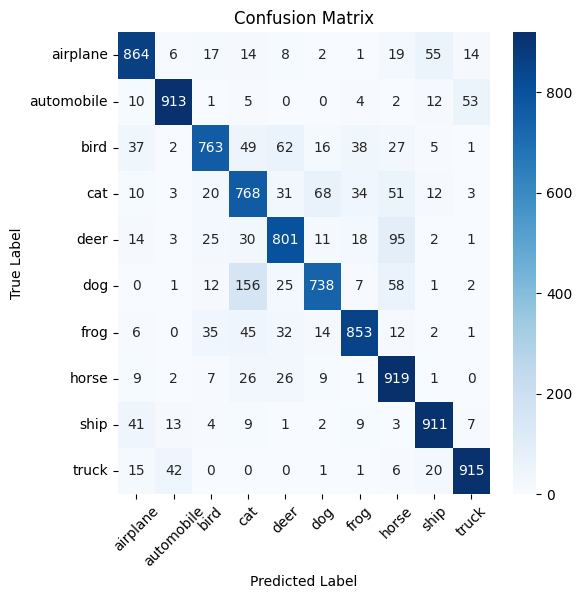

In [26]:
cm = confusion_matrix(y_test, y_pred_a)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


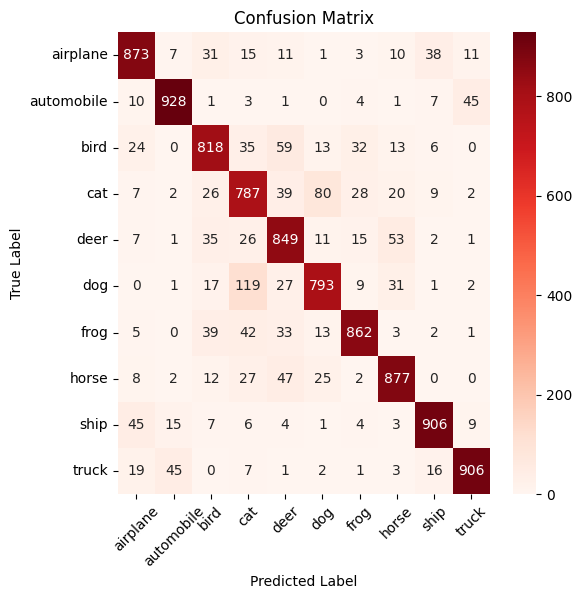

In [27]:
cm = confusion_matrix(y_test, y_pred_s)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


In [29]:
# base_model.trainable = True

# # Freeze all layers except the last N (e.g., last 20 layers)
# fine_tune_at = len(base_model.layers) - 20
# for layer in base_model.layers[:fine_tune_at]:
#     layer.trainable = False
base_model.trainable = True
for layer in base_model.layers[:-15]:  # keep most layers frozen, fine-tune last 30
    layer.trainable = False

In [30]:
from tensorflow.keras import optimizers

#### Fine tuning

In [31]:
load_model_a.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training (fine-tuning)
fine_tune_epochs = 8
total_epochs = 3 + fine_tune_epochs  # if trained earlier 3 epochs

history_fine_a_mobnet = load_model_a.fit(
    X_train_ds,
    validation_data=X_test_ds,
    epochs=total_epochs,
    initial_epoch=3,callbacks= ModelCheckpoint(filepath='mobnetfintun_a_bm.keras',monitor='val_loss',
    save_best_only=True,mode='min',verbose=1))


Epoch 4/11
3123/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8531 - loss: 0.4189
Epoch 4: val_loss improved from inf to 0.41689, saving model to mobnetfintun_a_bm.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 72s 20ms/step - accuracy: 0.8531 - loss: 0.4189 - val_accuracy: 0.8563 - val_loss: 0.4169
Epoch 5/11
3123/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8662 - loss: 0.3880
Epoch 5: val_loss improved from 0.41689 to 0.41433, saving model to mobnetfintun_a_bm.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 58s 18ms/step - accuracy: 0.8662 - loss: 0.3879 - val_accuracy: 0.8594 - val_loss: 0.4143
Epoch 6/11
3123/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8682 - loss: 0.3799
Epoch 6: val_loss improved from 0.41433 to 0.41335, saving model to mobnetfintun_a_bm.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 58s 19ms/step - accuracy: 0.8682 - loss: 0.3799 - val_accuracy: 0.8594 - val_loss: 0.4134
Epoch 7/11
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8693 - loss: 0.3786
Epoch 7: 

In [32]:
load_model_s.compile(
    optimizer=optimizers.SGD(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training (fine-tuning)
fine_tune_epochs = 12
total_epochs = 6 + fine_tune_epochs  # if trained earlier 3 epochs

history_fine_s_mobnet = load_model_s.fit(
    X_train_ds,
    validation_data=X_test_ds,
    epochs=total_epochs,
    initial_epoch=3,callbacks= ModelCheckpoint(filepath='mobnetfintun_s_bm.keras',monitor='val_loss',
    save_best_only=True,mode='min',verbose=1))

Epoch 4/18
3124/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8845 - loss: 0.3278
Epoch 4: val_loss improved from inf to 0.40487, saving model to mobnetfintun_s_bm.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 77s 22ms/step - accuracy: 0.8845 - loss: 0.3278 - val_accuracy: 0.8606 - val_loss: 0.4049
Epoch 5/18
3122/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8838 - loss: 0.3281
Epoch 5: val_loss improved from 0.40487 to 0.40363, saving model to mobnetfintun_s_bm.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 58s 18ms/step - accuracy: 0.8838 - loss: 0.3281 - val_accuracy: 0.8610 - val_loss: 0.4036
Epoch 6/18
3123/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8850 - loss: 0.3273
Epoch 6: val_loss improved from 0.40363 to 0.40278, saving model to mobnetfintun_s_bm.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 60s 19ms/step - accuracy: 0.8850 - loss: 0.3273 - val_accuracy: 0.8610 - val_loss: 0.4028
Epoch 7/18
3123/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8872 - loss: 0.3205
Epoch 7: 

In [33]:
load_a_bm = load_model('mobnetfintun_a_bm.keras')
load_s_bm = load_model('mobnetfintun_s_bm.keras')

In [34]:
test_loss_fntun, test_acc_fntun = load_a_bm.evaluate(X_test_ds)
print(f"Test Accuracy after fine-tuning: {test_acc_fntun:.4f}")
print(f"Test Loss after fine-tuning: {test_loss_fntun:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.8561 - loss: 0.4179
Test Accuracy after fine-tuning: 0.8604
Test Loss after fine-tuning: 0.4091


In [35]:
test_loss_fntun, test_acc_fntun = load_s_bm.evaluate(X_test_ds)
print(f"Test Accuracy after fine-tuning: {test_acc_fntun:.4f}")
print(f"Test Loss after fine-tuning: {test_loss_fntun:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.8601 - loss: 0.4090
Test Accuracy after fine-tuning: 0.8619
Test Loss after fine-tuning: 0.3996


In [43]:
y_pred_probs_a_fntun = load_a_bm.predict(X_test_ds)
y_pred_a_fntn = np.argmax(y_pred_probs_a_fntun, axis=1)

625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step


In [44]:
y_pred_probs_s_fntun = load_s_bm.predict(X_test_ds)
y_pred_s_fntn = np.argmax(y_pred_probs_s_fntun, axis=1)

625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step


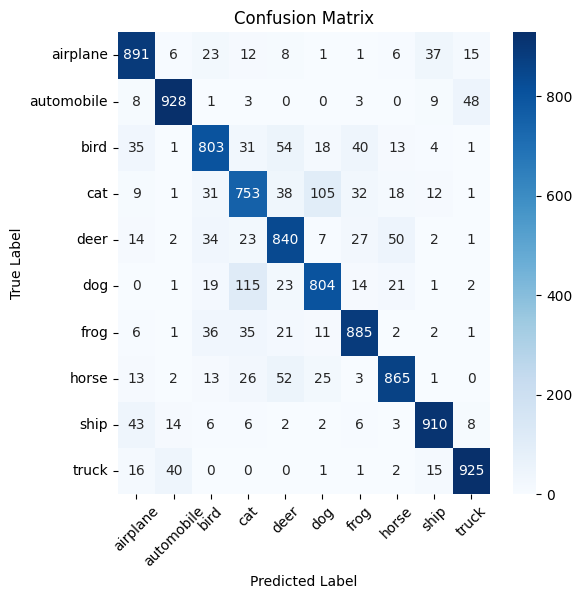

In [45]:
cm = confusion_matrix(y_test, y_pred_a_fntn)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

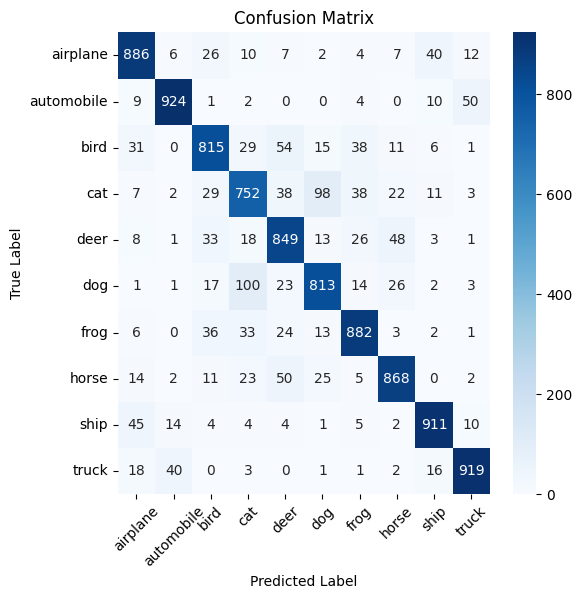

In [46]:
cm = confusion_matrix(y_test, y_pred_s_fntn)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# DenseNet121

In [52]:
from tensorflow.keras.applications import DenseNet121

In [55]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.densenet import preprocess_input as ppi

# One-hot encode labels
y_train_cat_densenet = to_categorical(y_train, 10)
y_test_cat_densenet = to_categorical(y_test, 10)

# Define resize size (DenseNet expects 224x224 typically)
IMG_SIZE = 224
BATCH_SIZE = 16  # adjust based on GPU RAM

# Create tf.data datasets
X_train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train_cat_densenet))
X_test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test_cat_densenet))

# Preprocessing function
def preprocess_densenet(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))  # resize to (224,224)
    image = ppi(image)
    return image, label

# Apply preprocessing + batching + prefetching
X_train_ds = X_train_ds.map(preprocess_densenet).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
X_test_ds  = X_test_ds.map(preprocess_densenet).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [56]:
# Build DenseNet-121 base
base_model_dense = DenseNet121(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                         include_top=False,
                         weights="imagenet")
base_model_dense.trainable = False  # freeze base initially

# Add custom head
model_densenet = models.Sequential([
    base_model_dense,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),                  # prevent overfitting
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile
model_densenet.compile(optimizer= optimizers.Adam(learning_rate=1e-4),
                       loss="categorical_crossentropy",
                       metrics=["accuracy"])

# Train
history_densenet = model_densenet.fit(
    X_train_ds,
    validation_data= X_test_ds,
    epochs=10,
    verbose=1,
    callbacks= ModelCheckpoint(filepath='densenet_a_bm.keras',monitor='val_loss',
    save_best_only=True,mode='min',verbose=1)
)

Epoch 1/10
3124/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5330 - loss: 1.3818
Epoch 1: val_loss improved from inf to 0.43917, saving model to densenet_a_bm.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 187s 53ms/step - accuracy: 0.5331 - loss: 1.3815 - val_accuracy: 0.8538 - val_loss: 0.4392
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7950 - loss: 0.5940
Epoch 2: val_loss improved from 0.43917 to 0.38420, saving model to densenet_a_bm.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 177s 48ms/step - accuracy: 0.7950 - loss: 0.5940 - val_accuracy: 0.8698 - val_loss: 0.3842
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8136 - loss: 0.5453
Epoch 3: val_loss improved from 0.38420 to 0.37707, saving model to densenet_a_bm.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 203s 49ms/step - accuracy: 0.8136 - loss: 0.5453 - val_accuracy: 0.8708 - val_loss: 0.3771
Epoch 4/10
3124/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8183 - loss: 0.5298
Epoch 4: val_loss 

In [57]:
load_a_densnet = load_model("densenet_a_bm.keras")

In [59]:
test_loss_densnet, test_acc_densnet = load_a_densnet.evaluate(X_train_ds)
print(f"Test Accuracy after fine-tuning: {test_acc_densnet:.4f}")
print(f"Test Loss after fine-tuning: {test_loss_densnet:.4f}")

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 130s 42ms/step - accuracy: 0.8921 - loss: 0.3214
Test Accuracy after fine-tuning: 0.8934
Test Loss after fine-tuning: 0.3187


In [60]:
test_loss_densnet, test_acc_densnet = load_a_densnet.evaluate(X_test_ds)
print(f"Test Accuracy after fine-tuning: {test_acc_densnet:.4f}")
print(f"Test Loss after fine-tuning: {test_loss_densnet:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.8841 - loss: 0.3465
Test Accuracy after fine-tuning: 0.8842
Test Loss after fine-tuning: 0.3457


In [61]:
# Build DenseNet-121 base
base_model_dense = DenseNet121(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                         include_top=False,
                         weights="imagenet")
base_model_dense.trainable = False  # freeze base initially

# Add custom head
model_densenet_sgd = models.Sequential([
    base_model_dense,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),                  # prevent overfitting
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile
model_densenet_sgd.compile(optimizer= optimizers.SGD(learning_rate=1e-4),
                       loss="categorical_crossentropy",
                       metrics=["accuracy"])

# Train
history_densenet_sgd = model_densenet_sgd.fit(
    X_train_ds,
    validation_data= X_test_ds,
    epochs=10,
    verbose=1,
    callbacks= ModelCheckpoint(filepath='densenet_s_bm.keras',monitor='val_loss',
    save_best_only=True,mode='min',verbose=1)
)

Epoch 1/10
3124/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.1721 - loss: 2.5934
Epoch 1: val_loss improved from inf to 1.56086, saving model to densenet_s_bm.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 185s 52ms/step - accuracy: 0.1721 - loss: 2.5932 - val_accuracy: 0.5355 - val_loss: 1.5609
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3754 - loss: 1.7849
Epoch 2: val_loss improved from 1.56086 to 1.17967, saving model to densenet_s_bm.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 194s 53ms/step - accuracy: 0.3754 - loss: 1.7849 - val_accuracy: 0.6696 - val_loss: 1.1797
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5000 - loss: 1.4479
Epoch 3: val_loss improved from 1.17967 to 0.96476, saving model to densenet_s_bm.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 185s 48ms/step - accuracy: 0.5000 - loss: 1.4479 - val_accuracy: 0.7250 - val_loss: 0.9648
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5725 - loss: 1.2393
Epoch 4: val_loss 